In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm
from pywget import wget
import matplotlib.pyplot as plt
import seaborn as sns
import mapclassify
import descartes
from datetime import datetime
%matplotlib inline


In [3]:
urls = [
   'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
   'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
   'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']
[wget.download(url) for url in urls]

URLError: <urlopen error [Errno 11004] getaddrinfo failed>

In [5]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')

deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')

recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')


In [6]:
confirmed_df_melted = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    var_name='Date', 
    value_name='Confirmed')

deaths_df_melted = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    var_name='Date', 
    value_name='Deaths')

recovered_df_melted = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],  
    var_name='Date', 
    value_name='Recovered')

complete_df = confirmed_df_melted.merge(
  right=deaths_df_melted, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )


complete_df = complete_df.merge(
  right=recovered_df_melted, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )

complete_df['Date']=pd.to_datetime(complete_df['Date'])

complete_df['Active'] = complete_df['Confirmed'] - complete_df['Deaths'] - complete_df['Recovered']
complete_df = complete_df.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

temp = complete_df.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)
temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan
# renaming columns
temp.columns = ['Country/Region', 'Date', 'New_Cases', 'New_Deaths', 'New_Recovered']
# merging new values
complete_df = pd.merge(complete_df, temp, on=['Country/Region', 'Date'])
# filling na with 0
complete_df = complete_df.fillna(0)
# fixing data types
cols = ['Confirmed','Active','Recovered','New_Cases', 'New_Deaths', 'New_Recovered']
complete_df[cols] = complete_df[cols].astype('int')
# 
complete_df['New_Cases'] = complete_df['New_Cases'].apply(lambda x: 0 if x<0 else x)

complete_df=complete_df.set_index(complete_df['Date'])
complete_df.drop('Date',axis=1,inplace=True)

df_India = complete_df.loc[complete_df['Country/Region']=='India']

complete_df.info()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25192 entries, 2020-01-22 to 2020-06-03
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country/Region  25192 non-null  object
 1   Confirmed       25192 non-null  int32 
 2   Deaths          25192 non-null  int64 
 3   Recovered       25192 non-null  int32 
 4   Active          25192 non-null  int32 
 5   New_Cases       25192 non-null  int64 
 6   New_Deaths      25192 non-null  int32 
 7   New_Recovered   25192 non-null  int32 
dtypes: int32(5), int64(2), object(1)
memory usage: 1.2+ MB


In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.at[4,'name']='US'
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 5.6+ KB


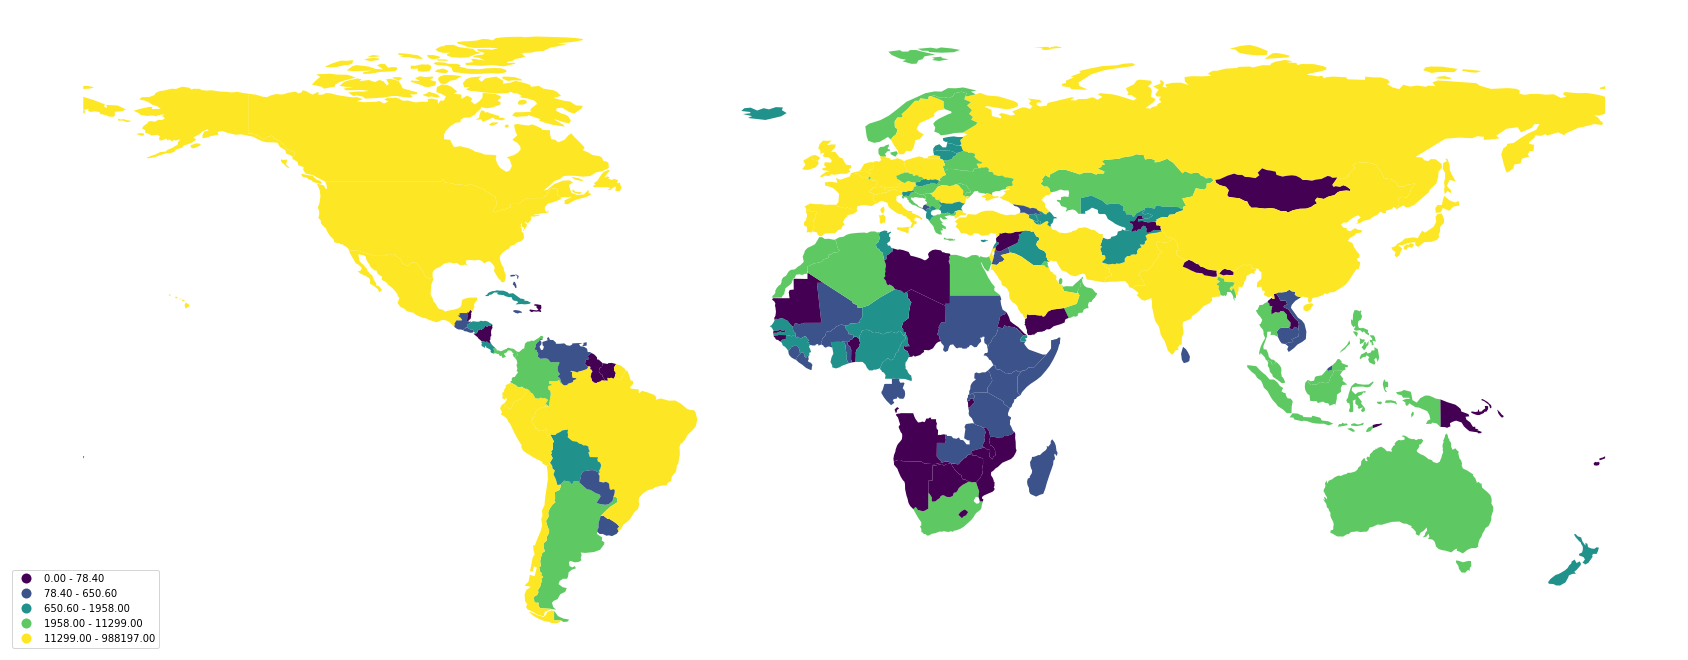

In [8]:
total_conf_cd = complete_df.loc['2020-04-27'][['Country/Region','Confirmed']]
plot_data = pd.merge(world, total_conf_cd, how='inner', right_on = 'Country/Region', left_on= 'name')
plot_data=gpd.GeoDataFrame(plot_data)

ax= plot_data.plot(column='Confirmed', scheme='quantiles',legend=True,legend_kwds={'loc': 'lower left'},figsize=(30,30))
ax.set_axis_off()
plt.style.use('classic')

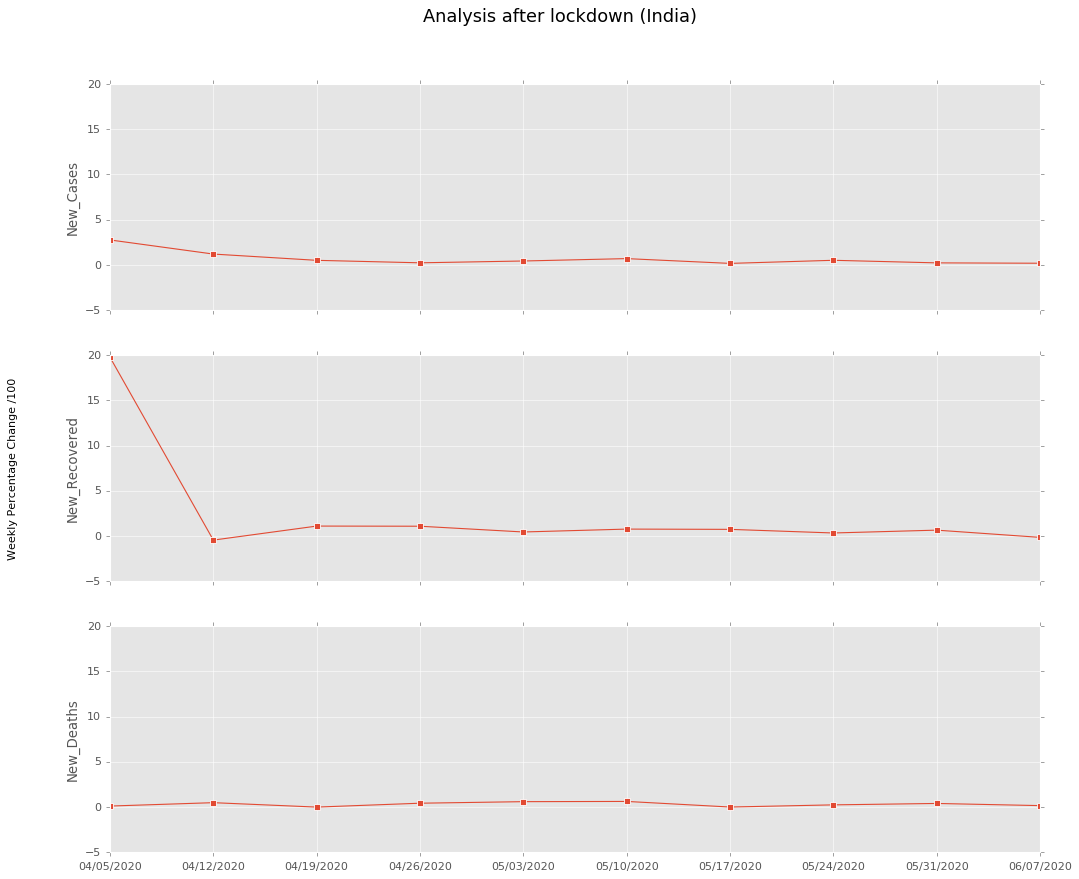

In [9]:
df_india_ld = df_India['2020-03-25':]

df_india_ld = df_india_ld.mask(df_india_ld==0).fillna(df_india_ld.mean())
df_india_ld_ncases = df_india_ld.New_Cases.resample('W').mean().pct_change().to_frame()
df_india_ld_nrecov = df_india_ld.New_Recovered.resample('W').mean().pct_change().to_frame()
df_india_ld_ndeath = df_india_ld.New_Deaths.resample('W').mean().pct_change().to_frame()

x = [x.date().strftime("%m/%d/%Y") for x in df_india_ld_ncases.index]

plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=3,sharey=True,sharex=True, figsize = (15,12))
fig.text(0.04,0.5,'Weekly Percentage Change /100', va='center', rotation='vertical')
fig.suptitle("Analysis after lockdown (India)", fontsize=16)
sns.lineplot(data = df_india_ld_ncases, x = x, y= df_india_ld_ncases['New_Cases'], marker = 's' , ax=ax[0])
sns.lineplot(data = df_india_ld_nrecov, x = x, y= df_india_ld_nrecov['New_Recovered'], marker = 's' , ax=ax[1])
sns.lineplot(data = df_india_ld_ndeath, x = x, y= df_india_ld_ndeath['New_Deaths'], marker = 's' , ax=ax[2])

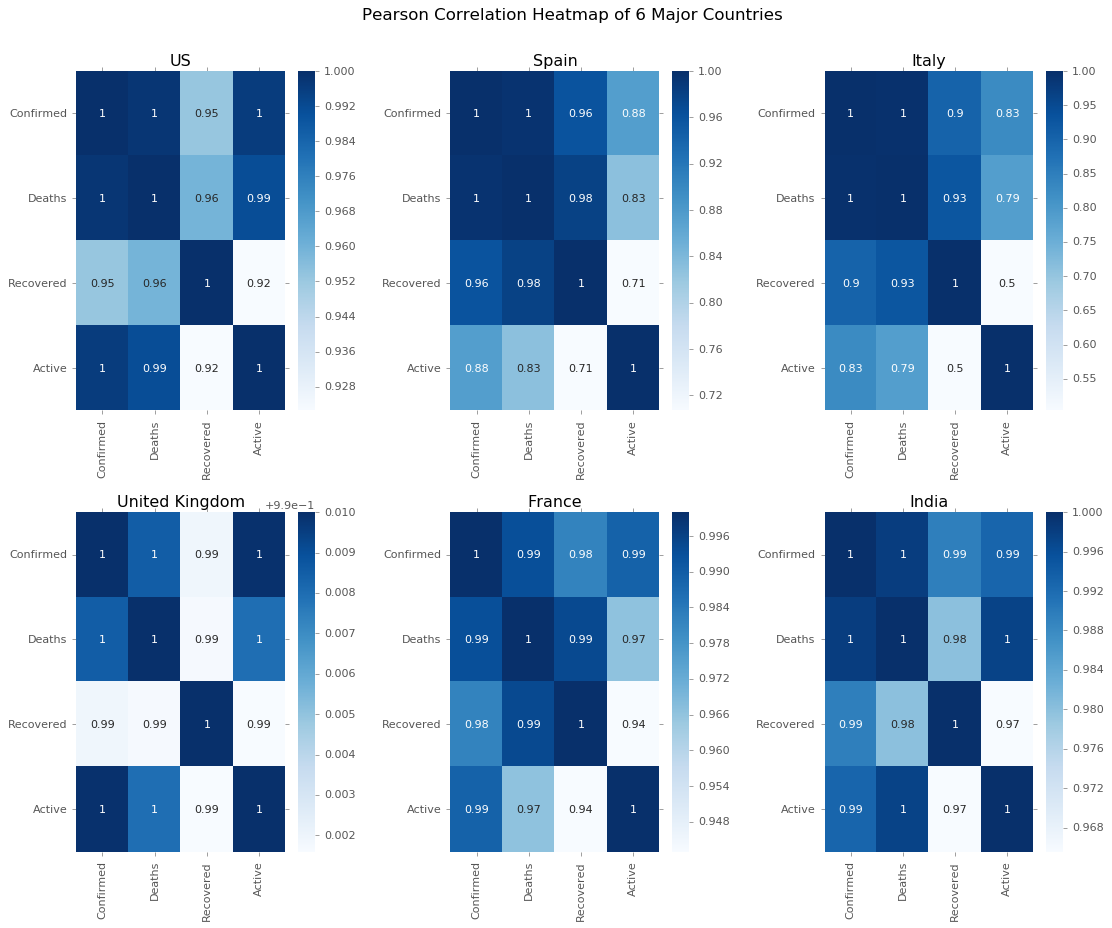

In [12]:
top_5_and_india = ['US','Spain','Italy','United Kingdom','France','India']

complete_df_corr = complete_df.loc[complete_df['Country/Region'].isin(top_5_and_india)].iloc[:,:5]

fig , ax = plt.subplots(nrows=2,ncols=3,figsize=(15,12))
fig.tight_layout(pad = 7.0)
fig.suptitle("Pearson Correlation Heatmap of 6 Major Countries" , fontsize = 15)
def plot_corr(m,i,j,t):
    sns.heatmap(m,ax=ax[i,j], cmap= 'Blues',annot = True)
    ax[i,j].set_title(t)
    ax[i,j].tick_params(axis='x', rotation=90)
    ax[i,j].tick_params(axis='y', rotation=0)
            
l = [[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]]
for i in range(6):
    data = complete_df_corr[complete_df_corr['Country/Region']==top_5_and_india[i]]
    mat = data.corr(method='pearson')
    x,y = l[i]
    plot_corr(mat,x,y,top_5_and_india[i])


Enter any country as input like : India, US, China, France, etc. : France


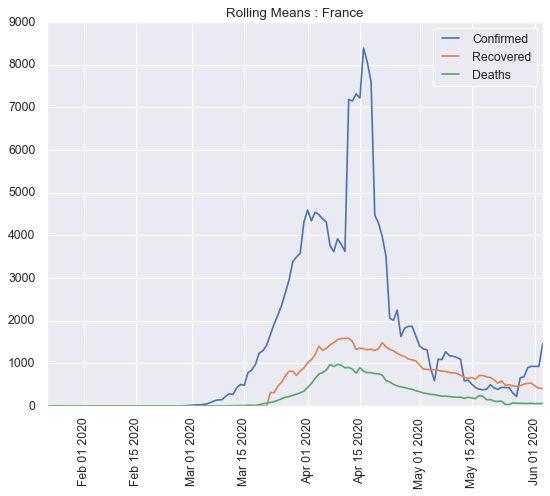

In [15]:
sns.set()
def plot_rolling_means(country):
    country_c = country['New_Cases'].rolling('7D').mean()
    country_r = country['New_Recovered'].rolling('7D').mean()
    country_d = country['New_Deaths'].rolling('7D').mean()
    sns.lineplot(data = country_c)
    sns.lineplot(data = country_r)
    sns.lineplot(data = country_d)
    plt.xticks(rotation = 90)
    plt.legend(['Confirmed','Recovered','Deaths'])
    plt.title("Rolling Means : " + s)

s = input("Enter any country as input like : India, US, China, France, etc. : ")
df_country = complete_df.loc[complete_df['Country/Region']==s]
plot_rolling_means(df_country)

Enter any country as input like : India, US, China, France, etc. : to show their Mortality and Death RateFrance


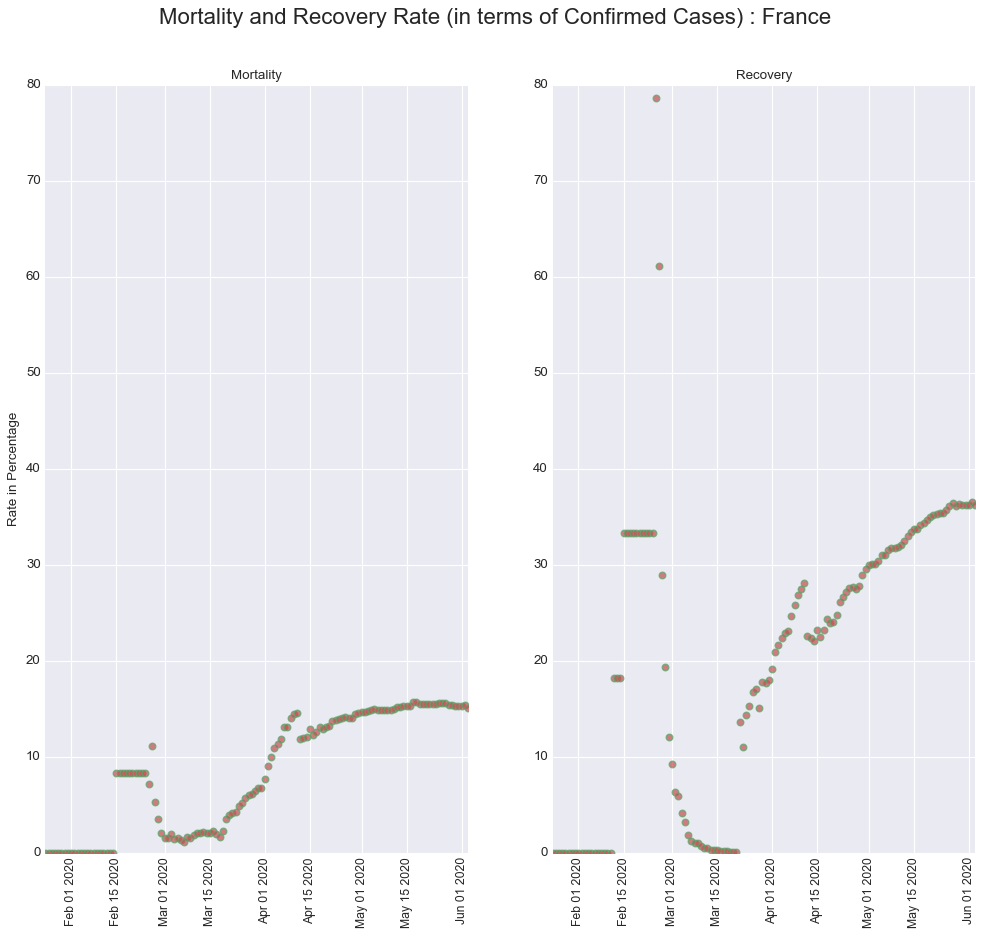

In [19]:
country = input("Enter any country as input like : India, US, China, France, etc. : to show their Mortality and Death Rate")
df_country = complete_df.loc[complete_df['Country/Region']==country]
fig , ax = plt.subplots(ncols = 2,figsize=(15,12))
plt.style.use('seaborn-darkgrid')
def rates(data):
    mortality = data['Deaths']/data['Confirmed'] * 100
    recovery = data['Recovered']/data['Confirmed'] * 100
    ax1 = plt.subplot(1,2,1)
    plt.plot(data.index,mortality , marker = 'o' , linewidth = 0 , alpha = 0.7 , markersize = 6 , 
             markeredgecolor = 'g' , markeredgewidth = 1.2 , markerfacecolor='r')
    plt.xticks(rotation = 90)
    plt.yticks(size = 12)
    plt.ylabel("Rate in Percentage" , fontsize = 12)
    plt.title("Mortality")
    ax2 = plt.subplot(1,2,2 ,sharey = ax1)
    plt.plot(data.index, recovery , marker = 'o' , linewidth = 0 , alpha = 0.7 , markersize = 6 ,
             markeredgecolor = 'g' , markeredgewidth = 1.2 , markerfacecolor='r')
    plt.xticks(rotation = 90)
    plt.yticks(size = 12)
    plt.title("Recovery")
    fig.suptitle("Mortality and Recovery Rate (in terms of Confirmed Cases) : " + country , fontsize = 20)
    plt.show()
rates(df_country)